In [1]:
import time
start_time = time.time()

In [2]:
import os
import contextlib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

warnings.filterwarnings('ignore', 'is_categorical_dtype')
warnings.filterwarnings('ignore', 'use_inf_as_na')
sns.set_theme(style='whitegrid')  

DATA_PATH = '../data'
TARGET_COL = 'out.electricity.total.energy_consumption'
WEEKDAY_NAMES = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
MONTH_NAMES = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [3]:
def calculate_spectral_flatness(signal):
    signal = signal / np.sqrt(np.mean(signal**2))
    spectrum = np.abs(np.fft.rfft(signal))**2
    geometric_mean = np.exp(np.mean(np.log(spectrum)))
    arithmetic_mean = np.mean(spectrum)
    return geometric_mean / arithmetic_mean    


def smooth(signal, n=15):
    kernel = np.full(2*n+1, 1/(2*n+1))
    signal = np.apply_along_axis(np.pad, 0, signal.reshape(-1, 96), (n, n), mode="edge")
    signal = np.apply_along_axis(np.convolve, 0, signal, kernel, mode="valid").flatten()
    return signal


# load data
building_data = [
    pd.read_parquet(f'{DATA_PATH}/data/{building_num}.parquet')
    for building_num in range(1, 1278)
]

# feature engineering
total_yearly_energy_consumption = np.array([df[TARGET_COL].sum() for df in building_data])

temporal_features = []
for df in building_data:    
    dt = df.timestamp.dt
    df["month"] = dt.month
    df["time_of_week"] = (dt.dayofweek * 96) + (dt.hour * 4) + (dt.minute // 15)
    x = df.groupby(["month", "time_of_week"])[TARGET_COL].mean().values
    temporal_features.append((x - np.mean(x))/np.std(x))
    
temporal_features = np.array(temporal_features)

weekday_weekend_consumption_ratio = []
for df in building_data:
    x = df.groupby("time_of_week")[TARGET_COL].mean().values
    weekday_weekend_consumption_ratio.append(x[:96*5].mean() / x[96*5:].mean())
weekday_weekend_consumption_ratio = np.array(weekday_weekend_consumption_ratio)    

spectral_flatness = np.array([calculate_spectral_flatness(df[TARGET_COL]) for df in building_data])

predictability = []
for i, df in enumerate(building_data):
    mu, sigma = df[TARGET_COL].mean(), df[TARGET_COL].std()
    df["standardized_energy"] = (df[TARGET_COL].values - mu) / sigma
    df["prediction"] = smooth(df.standardized_energy.values)
    predictability.append(np.sqrt(np.mean((df.prediction - df.standardized_energy)**2)))
predictability =  1 - np.array(predictability)

In [4]:
def summarize_cluster(cluster_metadata, cluster_name):
    
    df = cluster_metadata.groupby(cluster_name).agg(
        building_count=(cluster_name, "size"),
        residential_count = ("size_cluster", lambda x : sum(x == "Residential")),
        commercial_count = ("size_cluster", lambda x : sum(x == "Commercial")),
        sum_total_yearly_energy_consumption=("total_yearly_energy_consumption", "sum"),
        mean_total_yearly_energy_consumption=("total_yearly_energy_consumption", "mean"),
        mean_weekday_weekend_consumption_ratio=("weekday_weekend_consumption_ratio", "mean"),
        mean_spectral_flatness=("spectral_flatness", "mean"),
        mean_predictability=("predictability", "mean"),
    )
    
    df["fraction_total_yearly_energy_consumption"] = df["sum_total_yearly_energy_consumption"] / df["sum_total_yearly_energy_consumption"].sum()

    # format
    df["building_count"] = [f"{x} ({100*x/1277:0.2f}%)" for x in df.building_count]
    df["residential_count"] = [f"{x} ({100*(x/1277):0.2f}%)" for x in df.residential_count]
    df["commercial_count"] = [f"{x} ({100*x/1277:0.2f}%)" for x in df.commercial_count]
    df["sum_total_yearly_energy_consumption"] = [f"{x/1e6:0.2f} GWh ({100*f:0.2f}%)" for x,f in zip(df.sum_total_yearly_energy_consumption, df.fraction_total_yearly_energy_consumption)]
    df["mean_total_yearly_energy_consumption"] = [f"{x/1e3:0.2f} MWh" for x in df.mean_total_yearly_energy_consumption]

    # reorder
    df = df[[
        'building_count',
        'residential_count',
        'commercial_count',
        'sum_total_yearly_energy_consumption',
        'mean_total_yearly_energy_consumption', 
        'mean_weekday_weekend_consumption_ratio', 
        'mean_spectral_flatness', 
        'mean_predictability', 
    ]]

    # rename
    df = df.rename(columns={
        'building_count': 'Building Count',
        'residential_count': 'Residential Building Count',
        'commercial_count': 'Commercial Building Count',
        'sum_total_yearly_energy_consumption': 'Group Consumption (yearly)',
        'mean_total_yearly_energy_consumption': 'Average Building Consumption (yearly)',
        'mean_weekday_weekend_consumption_ratio': 'Weekday/Weekend Consumption Ratio',
        'mean_spectral_flatness': 'Log Spectral Flatness',
        'mean_predictability': 'Predictability',       
    }).T

    cluster_display_name = cluster_name.replace("_", " ").title()
    df.columns = pd.MultiIndex.from_tuples([(cluster_display_name, x) for x in df.columns])

            
    return df


cluster_metadata = pd.DataFrame(dict(
    bldg_id = range(1,1278), 
    total_yearly_energy_consumption=total_yearly_energy_consumption,
    weekday_weekend_consumption_ratio=weekday_weekend_consumption_ratio,
    spectral_flatness=np.log10(spectral_flatness),
    predictability=predictability,
))

## Seasonality Clusters

In [5]:
cluster_metadata["size_cluster"] = np.where(total_yearly_energy_consumption > 35000, "Commercial", "Residential")


2 clusters


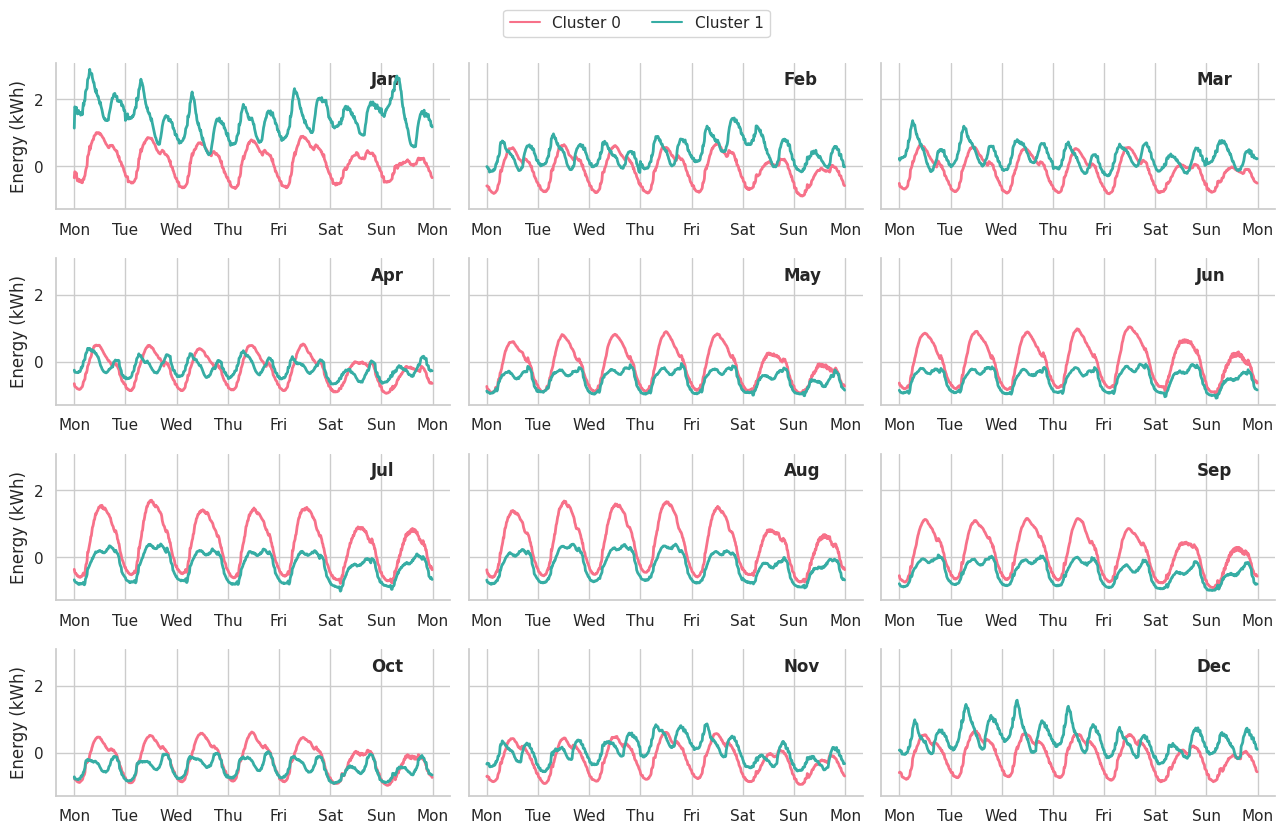

3 clusters


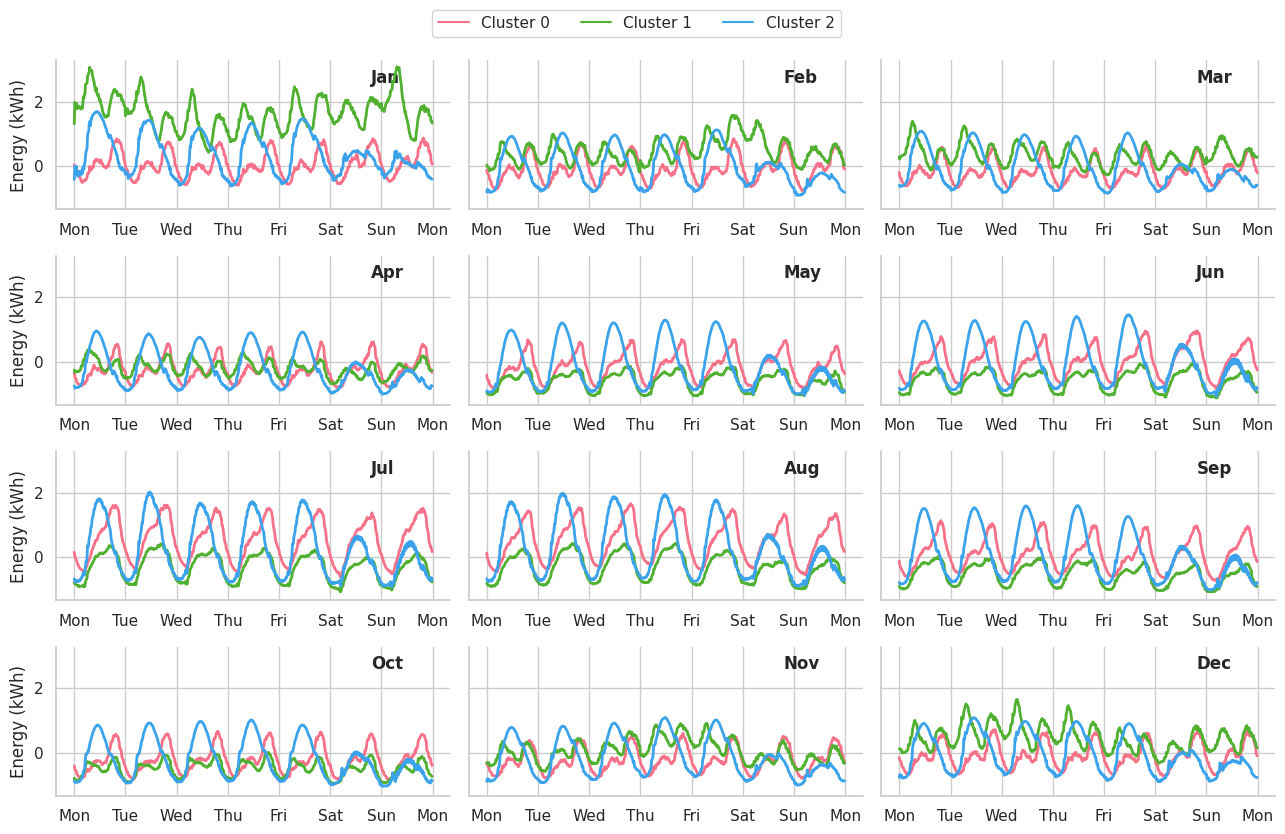

4 clusters


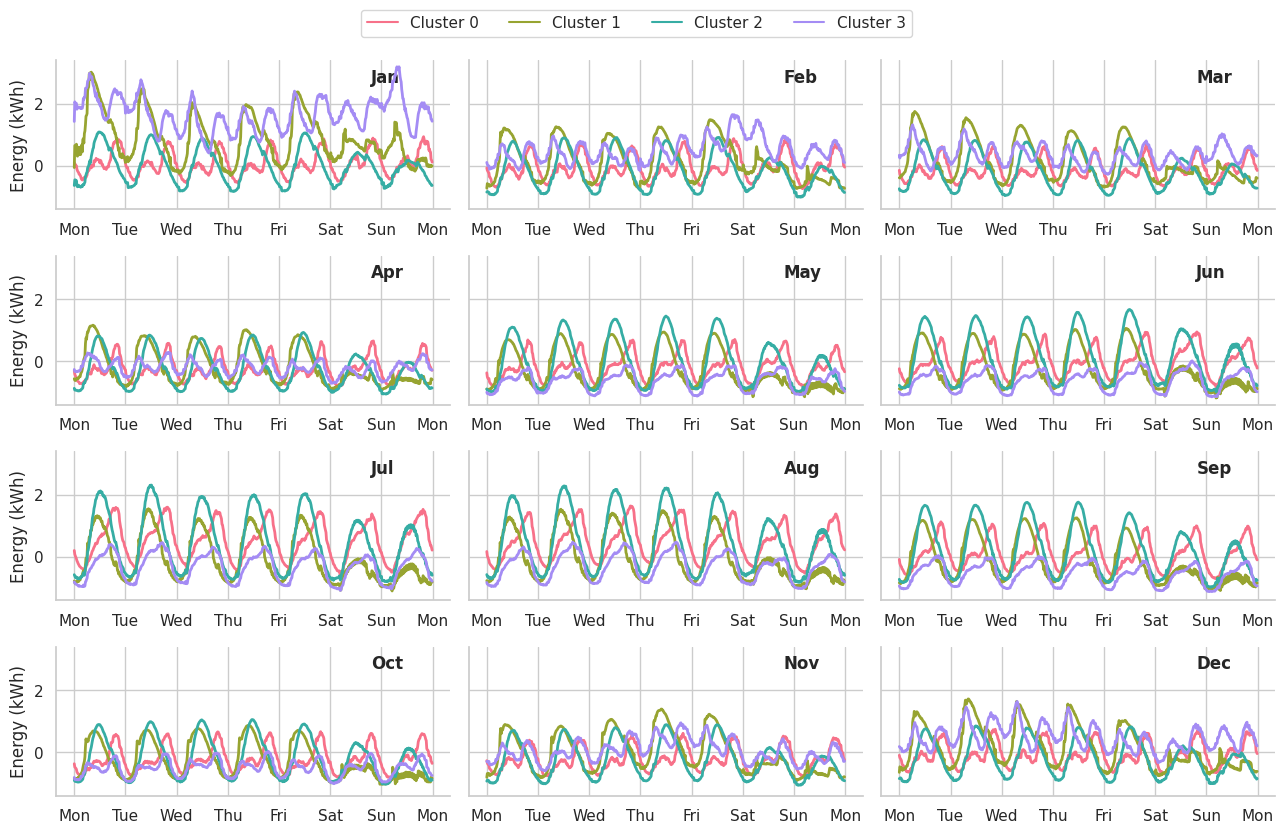

In [6]:
for n_clusters in [2, 3, 4]:
    
    print(f"{n_clusters} clusters")
    
    with contextlib.redirect_stderr(open(os.devnull, 'w')):        
        kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=1)
        seasonality_cluster_labels = kmeans.fit_predict(temporal_features)
    cluster_metadata["seasonality_cluster"] = seasonality_cluster_labels

    df = pd.concat([
        pd.DataFrame(dict(
            cluster_num=cluster_num,
            month_name=np.repeat([x[:3] for x in MONTH_NAMES], 7*96),
            time_of_week=np.tile(range(7*96), 12),
            value=temporal_features[seasonality_cluster_labels == cluster_num].mean(0)
        ))
        for cluster_num in range(n_clusters)    
    ])

    color_palette = sns.color_palette("husl", n_colors=n_clusters)

    g = sns.relplot(
        data=df,
        x="time_of_week", y="value", col="month_name", hue="cluster_num", units="cluster_num",
        estimator=None, kind="line", linewidth=2, zorder=5, col_wrap=3, height=2, aspect=2.0, 
        palette=color_palette

    )

    for month, ax in g.axes_dict.items():
        ax.text(.8, .85, month, transform=ax.transAxes, fontweight="bold")
        ax.xaxis.set_tick_params(which='both', labelbottom=True)
        ax.set_xticks(96*np.arange(8), [WEEKDAY_NAMES[i % 7][:3] for i in np.arange(8)])

    g.fig.subplots_adjust(hspace=0.1, wspace=0.1)        
    g._legend.set_visible(False)
    g.fig.legend(handles=g._legend.legend_handles, ncol=n_clusters, loc='upper center',
                 labels=[f"Cluster {i}" for i in range(n_clusters)], bbox_to_anchor=(0.5, 1.05))
    g.set_axis_labels("", "Energy (kWh)")    
    g.set_titles("")
    plt.tight_layout()
    plt.show()    

    summarize_cluster(cluster_metadata, "seasonality_cluster")

Say why 3 clusters is best

<a id="uncertainty-clusters"></a>
## Uncertainty-Based Clusters

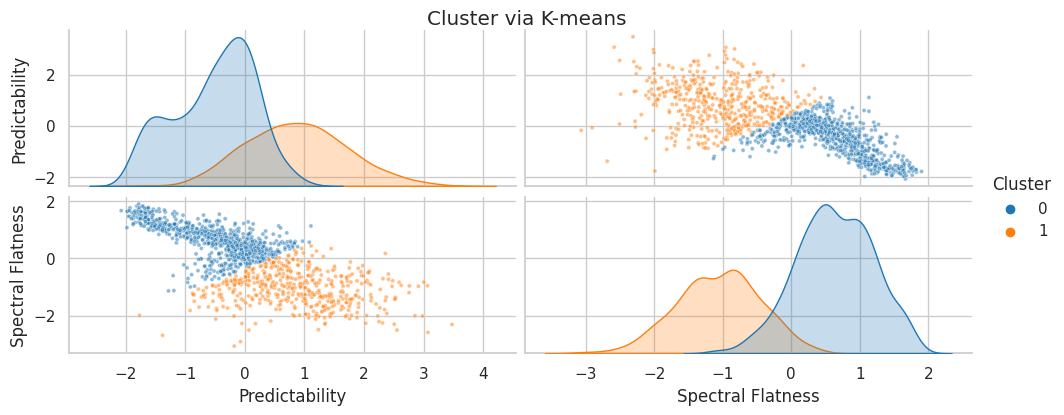

Uncertainty Cluster  \
                                          High Uncertainty   
Building Count                                801 (62.73%)   
Residential Building Count                    575 (45.03%)   
Commercial Building Count                     226 (17.70%)   
Group Consumption (yearly)             223.95 GWh (22.98%)   
Average Building Consumption (yearly)           279.59 MWh   
Weekday/Weekend Consumption Ratio                 1.161172   
Log Spectral Flatness                            -1.909862   
Predictability                                    0.262117   

                                                            
                                           Low Uncertainty  
Building Count                                476 (37.27%)  
Residential Building Count                      41 (3.21%)  
Commercial Building Count                     435 (34.06%)  
Group Consumption (yearly)             750.74 GWh (77.02%)  
Average Building Consumption (yearly)          1577.17 MWh  
Weekday/Weekend Consumption Ratio                 1.252322  
Log Spectral Flatness                            -3.447614  
Predictability                                    0.488045

In [7]:
n_clusters = 2

uncertainty_features = np.vstack([predictability, np.log10(spectral_flatness)]).T
uncertainty_features -= uncertainty_features.mean(0, keepdims=True)
uncertainty_features /= uncertainty_features.std(0, keepdims=True)

with contextlib.redirect_stderr(open(os.devnull, 'w')):    
    kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=1)
    uncertainty_cluster_labels = kmeans.fit_predict(uncertainty_features)

data = pd.DataFrame(uncertainty_features, columns=["Predictability", "Spectral Flatness"])
data['Cluster'] = uncertainty_cluster_labels  

sns.pairplot(data, hue='Cluster', palette="tab10", diag_kind="kde", markers=".",
             plot_kws={'alpha': 0.5}, height=2, aspect=2.5) 
plt.suptitle("Cluster via K-means", y=1.02)
plt.show()

cluster_metadata["uncertainty_cluster"] = np.where(uncertainty_cluster_labels == 1, "Low Uncertainty", "High Uncertainty")
summarize_cluster(cluster_metadata, "uncertainty_cluster")

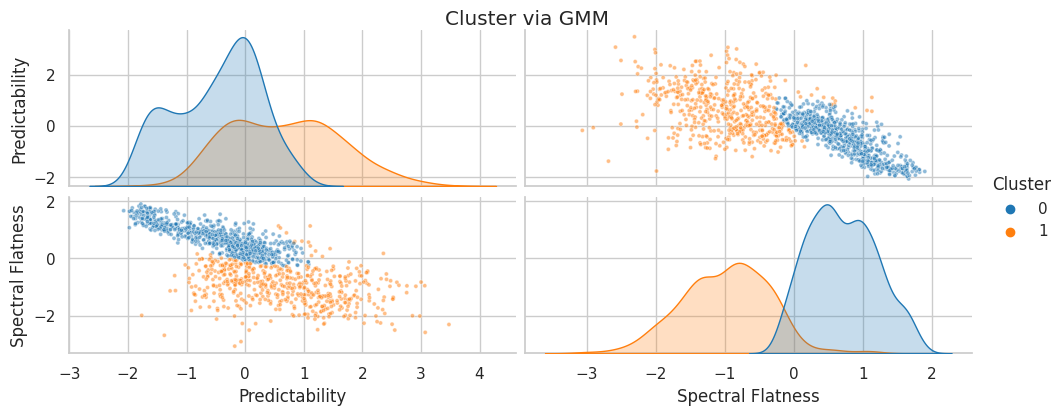

Uncertainty Cluster  \
                                          High Uncertainty   
Building Count                                743 (58.18%)   
Residential Building Count                    565 (44.24%)   
Commercial Building Count                     178 (13.94%)   
Group Consumption (yearly)             162.01 GWh (16.62%)   
Average Building Consumption (yearly)           218.05 MWh   
Weekday/Weekend Consumption Ratio                 1.118174   
Log Spectral Flatness                            -1.840491   
Predictability                                    0.267943   

                                                            
                                           Low Uncertainty  
Building Count                                534 (41.82%)  
Residential Building Count                      51 (3.99%)  
Commercial Building Count                     483 (37.82%)  
Group Consumption (yearly)             812.68 GWh (83.38%)  
Average Building Consumption (yearly)          1521.87 MWh  
Weekday/Weekend Consumption Ratio                 1.302248  
Log Spectral Flatness                            -3.377114  
Predictability                                      0.4554

In [8]:
n_clusters = 2
uncertainty_features = np.vstack([predictability, np.log10(spectral_flatness)]).T
uncertainty_features -= uncertainty_features.mean(0, keepdims=True)
uncertainty_features /= uncertainty_features.std(0, keepdims=True)

# GMM clustering
with contextlib.redirect_stderr(open(os.devnull, 'w')):    
    gmm = GaussianMixture(n_components=n_clusters, random_state=1)
    uncertainty_cluster_labels = gmm.fit_predict(uncertainty_features)

# Create DataFrame and plot
data = pd.DataFrame(uncertainty_features, columns=["Predictability", "Spectral Flatness"])
data['Cluster'] = uncertainty_cluster_labels

sns.pairplot(data, hue='Cluster', palette="tab10", diag_kind="kde", markers=".",
             plot_kws={'alpha': 0.5}, height=2, aspect=2.5) 
plt.suptitle("Cluster via GMM", y=1.02)
plt.show()

cluster_metadata["uncertainty_cluster"] = np.where(uncertainty_cluster_labels == 1, "Low Uncertainty", "High Uncertainty")
summarize_cluster(cluster_metadata, "uncertainty_cluster")

Talk about why GMM is better

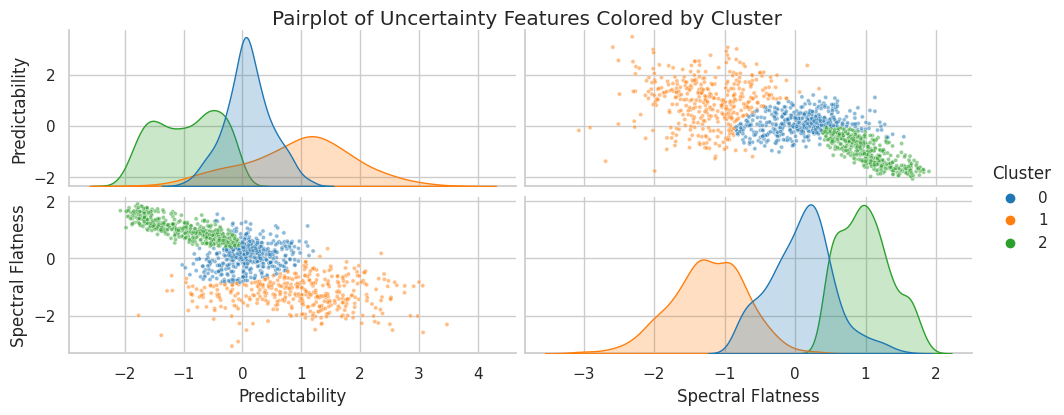

Uncertainty Cluster  \
                                          High Uncertainty   
Building Count                                892 (69.85%)   
Residential Building Count                    592 (46.36%)   
Commercial Building Count                     300 (23.49%)   
Group Consumption (yearly)             275.35 GWh (28.25%)   
Average Building Consumption (yearly)           308.69 MWh   
Weekday/Weekend Consumption Ratio                 1.179622   
Log Spectral Flatness                            -1.999213   
Predictability                                     0.27848   

                                                            
                                           Low Uncertainty  
Building Count                                385 (30.15%)  
Residential Building Count                      24 (1.88%)  
Commercial Building Count                     361 (28.27%)  
Group Consumption (yearly)             699.34 GWh (71.75%)  
Average Building Consumption (yearly)          1816.46 MWh  
Weekday/Weekend Consumption Ratio                  1.23112  
Log Spectral Flatness                            -3.604066  
Predictability                                    0.503536

In [9]:
n_clusters = 3
uncertainty_features = np.vstack([predictability, np.log10(spectral_flatness)]).T
uncertainty_features -= uncertainty_features.mean(0, keepdims=True)
uncertainty_features /= uncertainty_features.std(0, keepdims=True)

# GMM clustering
with contextlib.redirect_stderr(open(os.devnull, 'w')):    
    gmm = GaussianMixture(n_components=n_clusters, random_state=1)
    uncertainty_cluster_labels = gmm.fit_predict(uncertainty_features)

# Create DataFrame and plot
data = pd.DataFrame(uncertainty_features, columns=["Predictability", "Spectral Flatness"])
data['Cluster'] = uncertainty_cluster_labels

sns.pairplot(data, hue='Cluster', palette="tab10", diag_kind="kde", markers=".",
             plot_kws={'alpha': 0.5}, height=2, aspect=2.5) 
plt.suptitle("Pairplot of Uncertainty Features Colored by Cluster", y=1.02)
plt.show()

cluster_metadata["uncertainty_cluster"] = np.where(uncertainty_cluster_labels == 1, "Low Uncertainty", "High Uncertainty")
summarize_cluster(cluster_metadata, "uncertainty_cluster")

Say why 3 clusters is too much.